코딩 에이전트 만들기

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    """ The state of our agent """
    question: str
    certainty_score: int
    search_results: list
    web_score: str
    repo_name: str
    generation: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [27]:
def check_certainty(state: AgentState) -> AgentState:
    """ Evaluate certainty score for the query. """
    question = state["question"]
    class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")

    certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

    print("----CHECKING LLM'S CERTAINTY----")

    return {
        "certainty_score": certainty_scorer.invoke({"question": question}).score
    }

def route_based_on_certainty(state: AgentState) -> Literal["web_search", "direct_response"]:
    """ Route to appropriate node based on certainty score."""
    score = state["certainty_score"]

    if score != 100:
        print("----LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH")
    else :
        print("----LLM IS CERTAIN SO IT WILL DO DIRECT RESPONSE")

    return "web_search" if score != 100 else "direct_response"

In [4]:
#Test
question = "The implement methods of RAG using Langgraph"
class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")
score_response = llm.with_structured_output(CertaintyScoreResponse).invoke(question)
score_response

CertaintyScoreResponse(score=85)

In [29]:
def direct_response(state:AgentState):
    question = state['question']
    result = llm.invoke(question)
    return {"generation": result.content}

In [6]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

def web_search(state: AgentState) -> AgentState:
    """
    Perform web search and evaluate results
    """
    # Get origianl question
    question = state["question"]

    search_tool = TavilySearchResults(max_results=3)
    search_results = search_tool.run(question)
    
    class answer_availability(BaseModel):
        """Binary score for answer availability."""
        binary_score: str = Field(description="""
                    IF web search results can solve the user's ask, answer 'yes'.
                    If not, answer 'no' """)
    
    evaluator = llm.with_structured_output(answer_availability)
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate if these search results can answer the user's question with a simple yes/no."),
        ("user", """ Question: {question}\n\n Search Results:{results} \n\nCan these results answer the question adequately? """)
    ])

    print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")
    evaluation = evaluator.invoke(
        eval_prompt.format(
            question=question, results="\n".join(f"- {result['content']}" for result in search_results)
        )
    )

    return {
        "search_results": search_results,
        "web_score": evaluation.binary_score
    }

In [7]:
initial_state = AgentState (
    question="AutoRAG github에서 명시된 설치 방법을 알려줘",
    certainty_scor=85,
    search_results= [],
    web_score= "",
    repo_name= "",
    generation= "",
)

initial_state.update(web_search(initial_state))

initial_state

---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK


{'question': 'AutoRAG github에서 명시된 설치 방법을 알려줘',
 'certainty_scor': 85,
 'search_results': [{'url': 'https://github.com/Marker-Inc-Korea/AutoRAG/blob/main/docs/source/install.md',
   'content': 'AutoRAG/docs/source/install.md at main · Marker-Inc-Korea/AutoRAG · GitHub AutoRAG - Installation and Setup Learn how to install AutoRAG AutoRAG,RAG,AutoRAG install To install AutoRAG, you can use pip: pip install AutoRAG Due to the constraints, we recommend using Docker images for running AutoRAG on Windows. pip install "AutoRAG[gpu]" After installing this, you can install AutoRAG with parsing like below. pip install "AutoRAG[parse]" pip install "AutoRAG[ko]" pip install "AutoRAG[ja]" pip install python-dotenv And when you try to run AutoRAG, you can use below code to load .env file. And install AutoRAG to editable. And then, for testing and documentation build, you need to install some additional packages. If running in a CI/CD pipeline, consider using environment variables or .env files to ma

In [8]:
def route_after_search(state: AgentState) -> Literal["web_generate", "github_generate"]:
    """
    Route based on search evaluation
    """
    if state["web_score"] == "yes":
        print("---DECISION: web generate---")
        return "web_generate"
    else:
        print("---DECISION: github generate---")
        return "github_generate"

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def web_generate(state: AgentState):
    question = state['question']
    web_results = state["search_results"]
    def format_web_results(results):
        formatted=[]
        for i , result in enumerate(results, 1):
            formatted.append(f"Source {i}:\nURL: {result['url']}\nContent: {result['content']}\n")
        return "\n".join(formatted)
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates comprehensive answers based on search results.
                Use the provided search results to answer the user's question. Make sure to synthesize information from multiple sources when possible
                If the search results don't contain enough information to fully answer the question, acknowledge this limitation."""
        ),
        ("user", """Question: {question} \n Search Results:{web_results}\n Please provide a detailed answer based on the provided search results."""),
    ])
    chain = (
        {
            "question": lambda x: x["question"],
            "web_results": lambda x: format_web_results(x["web_results"]),
        }
        | prompt
        | llm
        | StrOutputParser()
    )

    print("--- Generating answer based on web search results")
    response = chain.invoke({
        "question": question,
        "web_results": web_results,
    })
    return {
        "generation": response
    }

In [10]:
# Test
initial_state.update(web_generate(initial_state))

initial_state

--- Generating answer based on web search results


{'question': 'AutoRAG github에서 명시된 설치 방법을 알려줘',
 'certainty_scor': 85,
 'search_results': [{'url': 'https://github.com/Marker-Inc-Korea/AutoRAG/blob/main/docs/source/install.md',
   'content': 'AutoRAG/docs/source/install.md at main · Marker-Inc-Korea/AutoRAG · GitHub AutoRAG - Installation and Setup Learn how to install AutoRAG AutoRAG,RAG,AutoRAG install To install AutoRAG, you can use pip: pip install AutoRAG Due to the constraints, we recommend using Docker images for running AutoRAG on Windows. pip install "AutoRAG[gpu]" After installing this, you can install AutoRAG with parsing like below. pip install "AutoRAG[parse]" pip install "AutoRAG[ko]" pip install "AutoRAG[ja]" pip install python-dotenv And when you try to run AutoRAG, you can use below code to load .env file. And install AutoRAG to editable. And then, for testing and documentation build, you need to install some additional packages. If running in a CI/CD pipeline, consider using environment variables or .env files to ma

In [21]:
from langchain_community.document_loaders import GithubFileLoader
from chromadb.config import Settings
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

def git_loader(repo, branch_name):
    loader = GithubFileLoader(
        repo=repo,
        branch=branch_name,
        access_token=os.getenv("GIT_TOKEN"),
        github_api_url="https://api.github.com",
        file_filter=lambda file_path: file_path.endswith(".md"),
    )
    documents = loader.load()
    return documents

def git_vector_embedding(repo_name):
    client = chromadb.Client(Settings(
        is_persistent=True,
        persist_directory="./chroma_db",
    ))

    collection_name = repo_name.split("/")[1]

    #Check if collection already exists
    existing_collections = client.list_collections()
    if collection_name in [col.name for col in existing_collections]:
        print(f"Loading existing collection for {collection_name}")
        vectorstore = Chroma(
            client=client,
            collection_name=collection_name,
            embedding_function=OpenAIEmbeddings(),
        )
    else:
        print(f"Creating new collection for {collection_name}")
        try:
            git_docs = git_loader(repo_name, "master")
        except:
            git_docs = git_loader(repo_name, "main")

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=50,
        )
        doc_splits = text_splitter.split_documents(git_docs)
        vectorstore = Chroma.from_documents(
            documents=doc_splits,
            collection_name=collection_name,
            embedding=OpenAIEmbeddings(),
            client=client,
        )
    return vectorstore

In [24]:
from langchain import hub

def github_generate(state: AgentState) -> AgentState:
    """
    Find relevant GitHub repositories for the user's question
    """
    class GitHubRepo(BaseModel):
        """Best matching GitHub repository"""
        repo_name: str = Field(description="Full repository name in format 'owner/repo'")
    
    question = state["question"]

    search_tool = TavilySearchResults(max_results=5)
    search_results = search_tool.invoke(f"github respository {question} site:github.com")

    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert at identifying the most relevant GitHub repository.
                Analyze the search results and identify the SINGLE MOST RELEVANT GitHub respository.
                Return ONLY the repository name in the format 'owner/repo'."""),
        ("user", """Question: {question}\nSearch Result: {results}\n What is the most relevant repository name?"""),
    ])

    repo_extractor = llm.with_structured_output(GitHubRepo)
    best_repo = repo_extractor.invoke(
        eval_prompt.format(question=question, results="\n\n".join(f"URL: {result['url']}\nContent: {result['content']}" for result in search_results))
    )
    repo_name = best_repo.repo_name
    vectorstore = git_vector_embedding(repo_name)
    retriever = vectorstore.as_retriever(search_kwargs=dict(k=10))
    retrieved_cchunks = []

    prompt = hub.pull('rlm/rag-prompt')
    
    def format_docs(docs):
        nonlocal retrieved_cchunks
        retrieved_cchunks = [{
            'content': doc.page_content,
            'metadata' : doc.metadata,
        } for doc in docs]

        return "\n\n".join(doc.page_content for doc in docs)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """ You are a helpful assistant that generates comprehensive answers based on GitHub repository."""),
        ("user", """Question: {question}\nGithub Retrieved Results:{context} \n\n
            Analyze the retriieved results and answer concisely. If you don't know the answer, you should answer 
            like 'I don't know' """)
    ])
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    print("--- GENERATING BASED ON GITHUB REPO SEARCH RESULTS ")
    result = rag_chain.invoke(question)
    return {
        "repo_name": repo_name,
        "generation":result,
        "github_chunks" : retrieved_cchunks
    }

In [25]:
# Test
initial_state.update(github_generate(initial_state))

initial_state

Loading existing collection for AutoRAG
--- GENERATING BASED ON GITHUB REPO SEARCH RESULTS 


{'question': 'AutoRAG github에서 명시된 설치 방법을 알려줘',
 'certainty_scor': 85,
 'search_results': [{'url': 'https://github.com/Marker-Inc-Korea/AutoRAG/blob/main/docs/source/install.md',
   'content': 'AutoRAG/docs/source/install.md at main · Marker-Inc-Korea/AutoRAG · GitHub AutoRAG - Installation and Setup Learn how to install AutoRAG AutoRAG,RAG,AutoRAG install To install AutoRAG, you can use pip: pip install AutoRAG Due to the constraints, we recommend using Docker images for running AutoRAG on Windows. pip install "AutoRAG[gpu]" After installing this, you can install AutoRAG with parsing like below. pip install "AutoRAG[parse]" pip install "AutoRAG[ko]" pip install "AutoRAG[ja]" pip install python-dotenv And when you try to run AutoRAG, you can use below code to load .env file. And install AutoRAG to editable. And then, for testing and documentation build, you need to install some additional packages. If running in a CI/CD pipeline, consider using environment variables or .env files to ma

In [31]:
from langgraph.graph import StateGraph, START, END
workflow = StateGraph(AgentState)

workflow.add_node("check_certainty", check_certainty)
workflow.add_node("direct_response", direct_response)
workflow.add_node("web_search", web_search)
workflow.add_node("web_generate", web_generate)
workflow.add_node("github_generate", github_generate)


workflow.add_edge(START, "check_certainty")
workflow.add_conditional_edges(
    "check_certainty",
    route_based_on_certainty,
    {
        "web_search": "web_search",
        "direct_response": "direct_response",
    }
)
workflow.add_conditional_edges(
    "web_search",
    route_after_search,
    {
        "web_generate": "web_generate",
        "github_generate": "github_generate",
    }
)

workflow.add_edge("direct_response", END)
workflow.add_edge("web_generate", END)
workflow.add_edge("github_generate", END)

graph = workflow.compile()

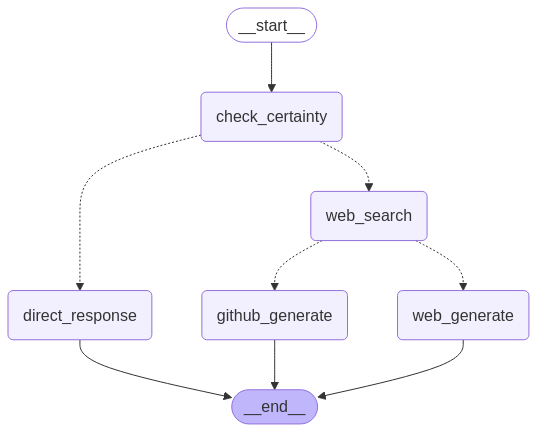

In [32]:
from util import display_graph

display_graph(graph)